<a href="https://colab.research.google.com/github/TitanSage02/Vox-Thymio/blob/main/v2/notebooks/classification_intention_robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification d'intention pour Thymio - Notebook complet

Ce notebook contient toutes les étapes pour entraîner un modèle de classification d'intentions basé sur BERT, depuis l'exploration des données jusqu'à la sauvegarde du modèle.

## Étapes couvertes :
1. Chargement et exploration du jeu de données
2. Prétraitement du texte
3. Tokenization avec `BERT`
4. Entraînement du modèle
5. Évaluation sur un jeu de test
6. Sauvegarde du modèle

## 1. Chargement du jeu de données

In [1]:
import pandas as pd

# Chargement des données
df = pd.read_csv('Intent_dataset.csv')
df.head()

,text,label
0,Va en avant,avancer
1,Avance toi,avancer
2,Il faut aller devant,avancer
3,Mouvement vers l'avant,avancer
4,Déplace toi vers l'avant,avancer


## 2. Exploration des données

Nombre d'exemples : 1707


<Axes: title={'center': 'Répartition des intentions'}, xlabel='label'>

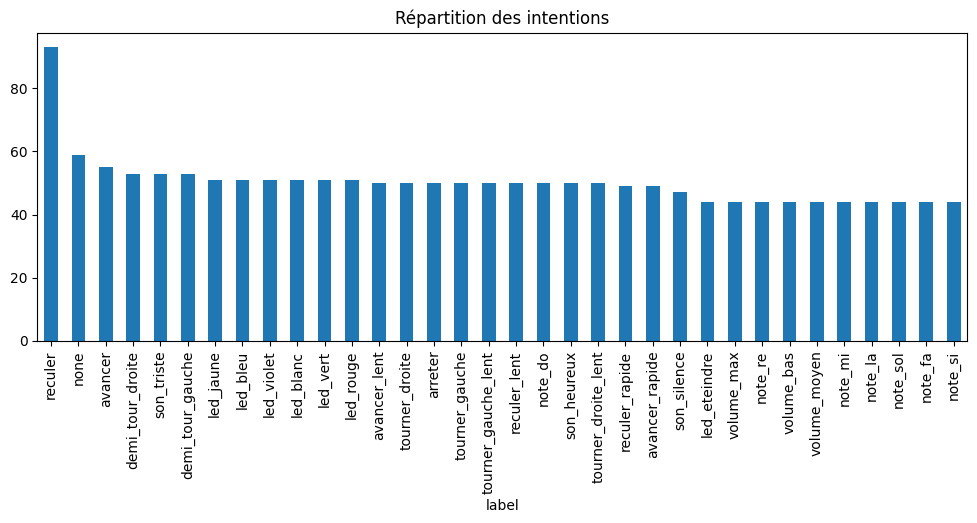

In [2]:
# Taille du jeu de données
print(f"Nombre d'exemples : {len(df)}")

# Répartition des classes
df['label'].value_counts().plot(kind='bar', figsize=(12,4), title="Répartition des intentions")

In [3]:
# On enlève les 40 échantillons de reculer avec random_state à 42
df = df.drop(df[(df['label'] == 'reculer')].sample(40, random_state=42).index)

<Axes: title={'center': 'Répartition des intentions'}, xlabel='label'>

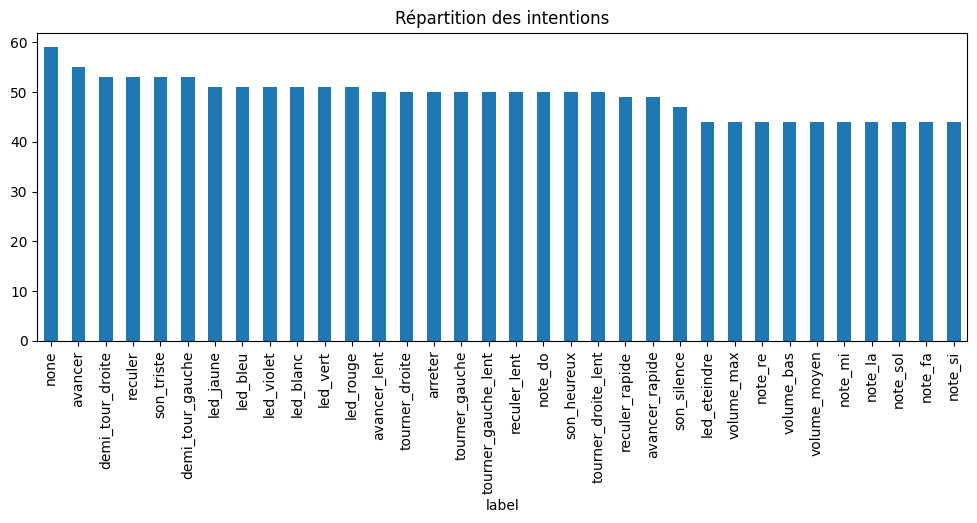

In [4]:
# Répartition des classes
df['label'].value_counts().plot(kind='bar', figsize=(12,4), title="Répartition des intentions")

## 3. Prétraitement du texte

In [5]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\sàâçéèêëîïôûùüÿñæœ'-]", '', text)
    return text

df['text'] = df['text'].apply(clean_text)

## 4. Préparation des données pour BERT

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

# Encodage des étiquettes
le = LabelEncoder() # One-Hot Encoding à voir après
df['label_id'] = le.fit_transform(df['label'])

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label_id'], test_size=0.2, random_state=42)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## 5. Dataset Torch

In [7]:
import torch

class IntentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = IntentDataset(train_encodings, list(y_train))
test_dataset = IntentDataset(test_encodings, list(y_test))

## 6. Entraînement du modèle BERT

In [8]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.6 MB/s eta 0:00:00


In [9]:
from transformers import EarlyStoppingCallback
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
import evaluate
import numpy as np

# Define metrics
def compute_metrics(eval_pred):
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = f1.compute(predictions=predictions, references=labels, average="weighted")["f1"]

    return {"accuracy": accuracy, "f1": f1}

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(le.classes_))

training_args = TrainingArguments(
    output_dir='/content/results',
    num_train_epochs=25,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir='/content/logs',
    logging_steps=5,
    report_to="none",
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="f1",  # Use f1 score to determine the best model
    greater_is_better=True # Higher f1 score is better
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Stop if f1 score doesn't improve for 3 epochs
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.952400,2.109072,0.476048,0.425860
2,0.913700,1.108383,0.607784,0.569077
3,0.763500,0.689689,0.739521,0.715597
4,0.175900,0.501414,0.859281,0.843996
5,0.189700,0.384463,0.892216,0.893440
6,0.157700,0.441619,0.886228,0.889438
7,0.038600,0.505729,0.886228,0.885739
8,0.105700,0.383863,0.922156,0.922939
9,0.006600,0.452984,0.901198,0.901697
10,0.195800,0.487274,0.910180,0.911961


TrainOutput(global_step=1837, training_loss=0.5883007360699348, metrics={'train_runtime': 576.6879, 'train_samples_per_second': 57.787, 'train_steps_per_second': 7.24, 'total_flos': 120597058300224.0, 'train_loss': 0.5883007360699348, 'epoch': 11.0})

## 7. Évaluation

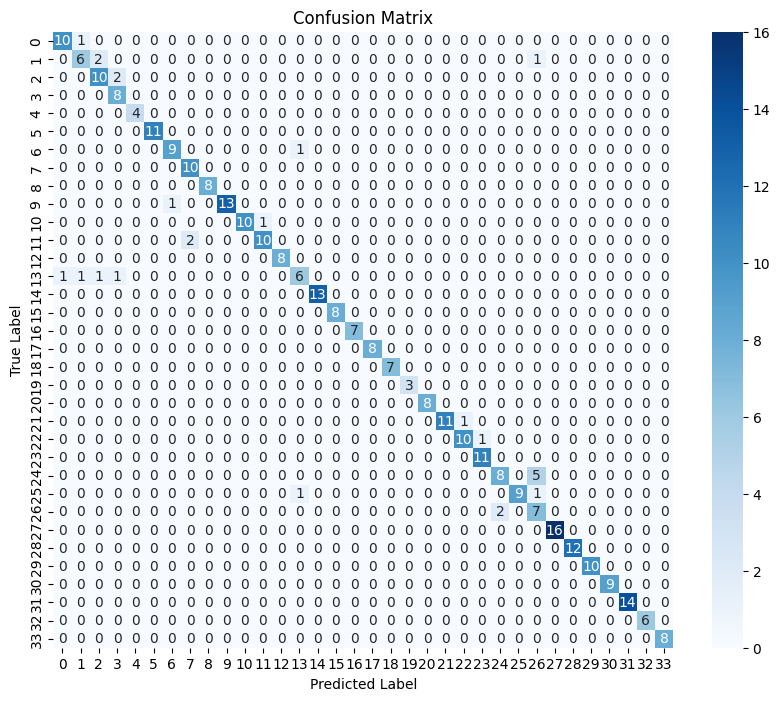

In [10]:
# Matrice de confusion

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [11]:
# Evaluation du modèle

trainer.evaluate()

{'eval_loss': 0.3838628828525543,
 'eval_accuracy': 0.9221556886227545,
 'eval_f1': 0.9229387806470415,
 'eval_runtime': 2.0643,
 'eval_samples_per_second': 161.8,
 'eval_steps_per_second': 20.346,
 'epoch': 11.0}

In [18]:
# Test the model with a few examples from the test set

for i in range(5, 16):
    example = test_dataset[i]
    input_ids = example['input_ids'].unsqueeze(0).to(model.device)
    attention_mask = example['attention_mask'].unsqueeze(0).to(model.device)
    true_label_id = example['labels'].item()

    # Get model prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_label_id = torch.argmax(logits, dim=1).item()

    # Get the actual labels using the label encoder
    true_label = le.inverse_transform([true_label_id])[0]
    predicted_label = le.inverse_transform([predicted_label_id])[0]

    print(f"Example {i+1}:")
    print(f"  Text: {X_test.iloc[i]}")
    print(f"  True Label: {true_label}")
    print(f"  Predicted Label: {predicted_label}")
    print("-" * 20)

Example 6:
  Text: progresse à fond la caisse
  True Label: avancer_rapide
  Predicted Label: avancer_rapide
--------------------
Example 7:
  Text: son d'affliction
  True Label: son_triste
  Predicted Label: son_triste
--------------------
Example 8:
  Text: déplace toi au ralenti
  True Label: avancer_lent
  Predicted Label: avancer_lent
--------------------
Example 9:
  Text: stoppe ta course
  True Label: arreter
  Predicted Label: arreter
--------------------
Example 10:
  Text: il faut y aller à donf arrière
  True Label: reculer_rapide
  Predicted Label: reculer_rapide
--------------------
Example 11:
  Text: penche lentement à gauche
  True Label: tourner_gauche_lent
  Predicted Label: tourner_gauche_lent
--------------------
Example 12:
  Text: gamme de do
  True Label: note_do
  Predicted Label: note_do
--------------------
Example 13:
  Text: nuance violette
  True Label: led_violet
  Predicted Label: led_violet
--------------------
Example 14:
  Text: régresse tranquilleme

## 8. Sauvegarde du modèle et de l’encodeur de labels

In [19]:
model.save_pretrained('./intent_model')
tokenizer.save_pretrained('./intent_model')

import joblib
joblib.dump(le, './intent_model/label_encoder.pkl')

['./intent_model/label_encoder.pkl']

In [21]:
!zip -r intent_model.zip ./intent_model

  adding: intent_model/ (stored 0%)
  adding: intent_model/label_encoder.pkl (deflated 46%)
  adding: intent_model/model.safetensors (deflated 7%)
  adding: intent_model/vocab.txt (deflated 53%)
  adding: intent_model/config.json (deflated 67%)
  adding: intent_model/special_tokens_map.json (deflated 42%)
  adding: intent_model/tokenizer_config.json (deflated 75%)


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import joblib
import re

class IntentClassifier:
    """
    Classe pour la classification d'intention utilisant un modèle BERT entraîné.
    Permet de charger le modèle, le tokenizer et l'encodeur de labels,
    de prétraiter le texte d'entrée et de prédire l'intention.
    """
    def __init__(self, model_path='./intent_model'):
        """
        Initialise le classificateur en chargeant le modèle, le tokenizer et l'encodeur de labels.

        Args:
            model_path (str): Chemin vers le répertoire contenant le modèle sauvegardé,
                              le tokenizer et l'encodeur de labels.
        """
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Utilisation du périphérique : {self.device}")

        # Chargement du tokenizer
        self.tokenizer = BertTokenizer.from_pretrained(model_path)
        print("Tokenizer chargé.")

        # Chargement du modèle
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.model.to(self.device) # Assure que le modèle est sur le bon périphérique
        self.model.eval() # Met le modèle en mode évaluation
        print("Modèle chargé et mis en mode évaluation.")

        # Chargement de l'encodeur de labels
        self.label_encoder = joblib.load(f'{model_path}/label_encoder.pkl')
        print("Encodeur de labels chargé.")

    def clean_text(self, text):
        """
        Prétraite le texte d'entrée en le mettant en minuscules et en supprimant
        les caractères spéciaux, sauf les lettres accentuées, les chiffres,
        les espaces, les tirets et les apostrophes.

        Args:
            text (str): Le texte à nettoyer.

        Returns:
            str: Le texte nettoyé.
        """
        text = text.lower()
        text = re.sub(r"[^\w\sàâçéèêëîïôûùüÿñæœ'-]", '', text)
        return text

    def predict(self, text):
        """
        Prédit l'intention d'un texte donné.

        Args:
            text (str): Le texte dont on veut prédire l'intention.

        Returns:
            str: Le label de l'intention prédite.
        """
        # Prétraitement du texte
        cleaned_text = self.clean_text(text)

        # Tokenization
        encoding = self.tokenizer(
            cleaned_text,
            return_tensors='pt', # Retourne des tenseurs PyTorch
            truncation=True,
            padding=True
        )

        # Déplacement des tenseurs sur le bon périphérique
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        # Prédiction
        with torch.no_grad(): # Désactive le calcul des gradients pour l'inférence
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predicted_label_id = torch.argmax(logits, dim=1).item()

        # Décodage du label prédit
        predicted_label = self.label_encoder.inverse_transform([predicted_label_id])[0]

        return predicted_label

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
!cp /content/intent_model.zip /content/drive/MyDrive/intent_model.zip

## Prêt pour l'inférence !